#### Tesis Magister Ingeniería Industrial
#### Autor: Kathyana Pérez

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta 

In [2]:
#generar datos basados en la media para predecir dias posteriores
def dias_extras(datos,dias_medias=10,dias_generar=10):

    aux = list(datos)
    for dia in np.arange(dias_generar):
        calculo = list(aux[-dias_medias:])
        aux.append(int(np.floor(np.mean(calculo))))
    return np.array(aux)

## Preprocesamiento Datos

### Instancia 2: Región del Ñuble

#### A. Pacientes en UCI

In [3]:
# UCI, producto 8
arch_p8 = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto8/UCI.csv'
df_uci = pd.read_csv(arch_p8)
df_uci = df_uci.iloc[9][3:] # Región de Ñuble
df_uci = df_uci.to_frame().reset_index().rename(columns={'index': 'dates', 9:'hospitalisations'})

Text(0.5, 1.0, 'Pacientes en unidad UCI COVID por día en la región del Ñuble')

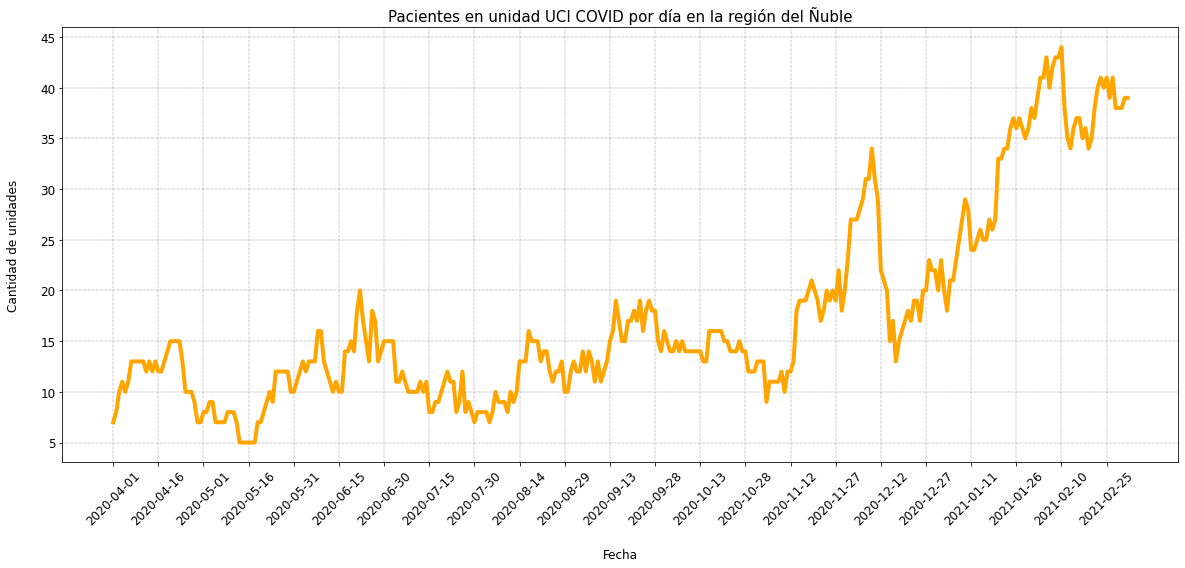

In [4]:
# Grafico imagen
plt.figure(figsize=(20,8))
plt.plot(df_uci.dates.values,df_uci.hospitalisations.values,linewidth=4, color = 'orange')
plt.xticks(df_uci.dates.values[::15],rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.grid(color='grey', ls = '-.', lw = 0.40)
plt.xlabel('Fecha', labelpad = 20, fontsize=12)
plt.ylabel('Cantidad de unidades',labelpad = 20,fontsize=12)
plt.title("Pacientes en unidad UCI COVID por día en la región del Ñuble",fontsize=15)

#### B. Examenes PCR

In [5]:
# PCR realizados, producto 7
arch_p7 = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto7/PCR.csv"
pcr = pd.read_csv(arch_p7)
pcr = pcr.iloc[9][3:] # Región del Biobío
pcr = pcr.to_frame().reset_index().rename(columns={'index': 'fecha', 9:'pcr'})

# Positividad, producto 55
arch_p55 = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto55/Positividad_por_region.csv'
positividad = pd.read_csv(arch_p55)
positividad = positividad[positividad['Region'] == 'Ñuble'].reset_index(drop = True).drop(['Region','Codigo region','region_residencia'], axis=1)

# Unir Datos
pcr_positivo = pcr.merge(positividad)

# positividad = test positivos / test totales
pcr_positivo["positivos"] = pcr_positivo["pcr"] * pcr_positivo["positividad"]

#los valores NA de la columna positivos seran '0'
pcr_positivo["positivos"] = pcr_positivo["positivos"].fillna(0).astype(int)
pcr_positivo["pcr"] = pcr_positivo["pcr"].fillna(0).astype(int)

Text(0.5, 1.0, 'PCR en Región de Ñuble por día')

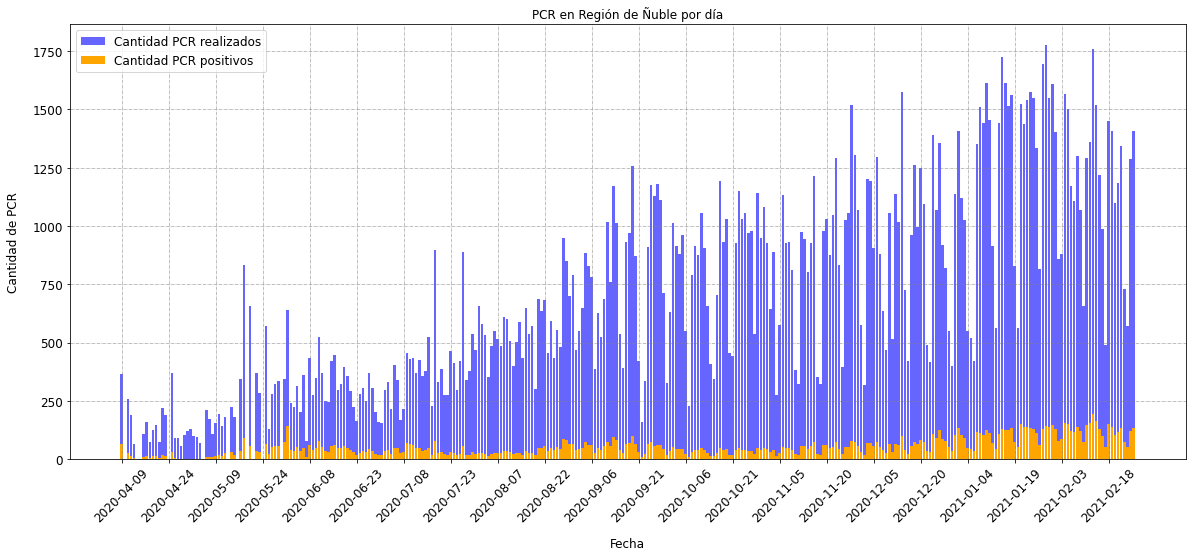

In [6]:
# Grafico imagen
plt.figure(figsize=(20,8))
plt.bar(pcr_positivo['fecha'], pcr_positivo['pcr'], label = 'Cantidad PCR realizados',  alpha=0.6, color = 'blue')
plt.bar(pcr_positivo['fecha'], pcr_positivo['positivos'], label = 'Cantidad PCR positivos', color = 'orange')
plt.xticks(pcr_positivo['fecha'][::15],rotation=45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.xlabel('Fecha',  labelpad = 12, fontsize = 12)
plt.ylabel('Cantidad de PCR',labelpad = 12, fontsize = 12)
plt.title('PCR en Región de Ñuble por día', fontsize = 12)
# plt.savefig('pcr_versus.png',bbox_inches = "tight")

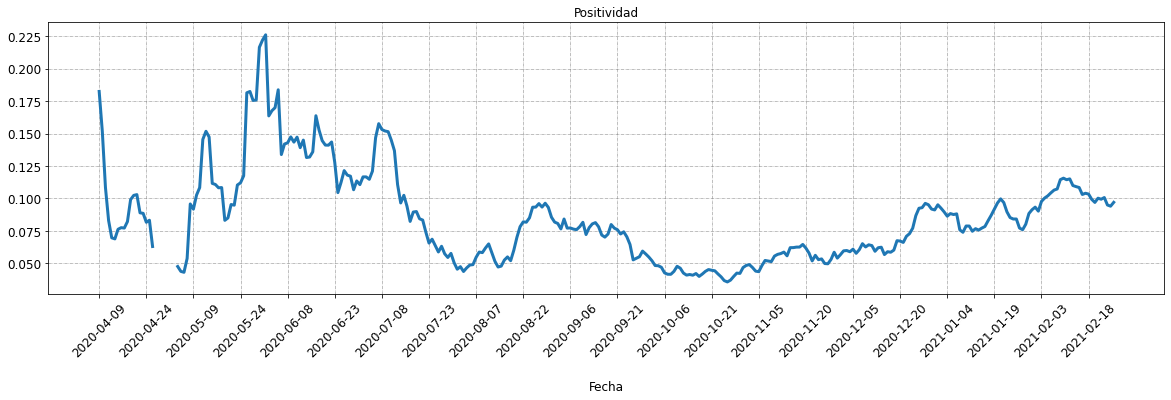

In [7]:
# Grafico positividad
plt.figure(figsize=(20,5))
plt.plot(pcr_positivo['fecha'], pcr_positivo['positividad'], linewidth = 3)
plt.xticks(pcr_positivo['fecha'][::15],rotation=45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.xlabel('Fecha',  labelpad = 20, fontsize = 12)
# plt.ylabel(labelpad = 20, fontsize = 20)
plt.title('Positividad', fontsize = 12)
plt.savefig('positividad.png',bbox_inches = "tight")

#### C. Camas Disponibles

In [8]:
# Camas UCI, producto 58
arch_p58 = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto58/Camas_UCI_diarias.csv"
camas = pd.read_csv(arch_p58)

# Ñuble
camas_covid    = camas.iloc[26][2:].to_frame().reset_index().rename(columns={'index': 'fecha', 26:'camas ocupadas covid'}) # Biobio
camas_no_covid = camas.iloc[43][2:].to_frame().reset_index().rename(columns={'index': 'fecha', 43:'camas ocupadas no covid'})# Biobio
camas_total    = camas.iloc[9][2:].to_frame().reset_index().rename(columns={'index': 'fecha', 9:'total camas'})
camas_ocupadas = camas.iloc[60][2:].to_frame().reset_index().rename(columns={'index': 'fecha', 60:'total camas ocupadas'})

In [9]:
camas_disponibles = pd.DataFrame()
camas_disponibles['fecha'] = camas_total['fecha']
camas_disponibles['camas disponibles'] = camas_total['total camas'].values - camas_ocupadas['total camas ocupadas'].values

Text(0.5, 1.0, 'Distribución de camas UCI en la región de Ñuble')

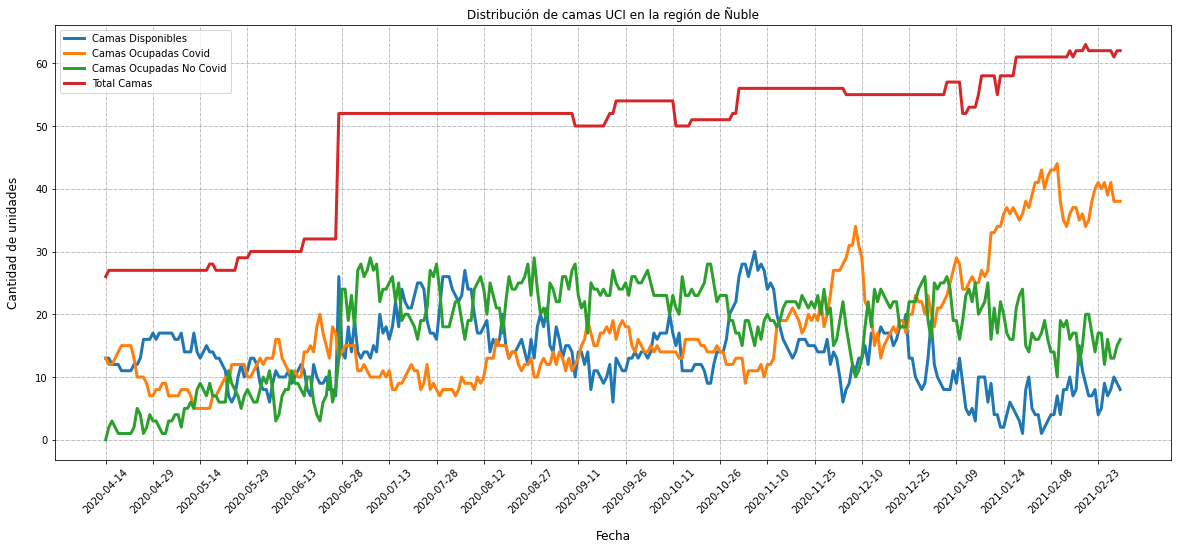

In [10]:
# Grafico imagen
plt.figure(figsize=(20,8))
plt.plot(camas_disponibles['fecha'].values , camas_disponibles['camas disponibles'].values,label = "Camas Disponibles",linewidth = 3)
plt.plot(camas_covid['fecha'].values , camas_covid['camas ocupadas covid'].values,label ='Camas Ocupadas Covid',linewidth = 3)
plt.plot(camas_no_covid['fecha'].values , camas_no_covid['camas ocupadas no covid'].values,label ='Camas Ocupadas No Covid',linewidth = 3)
plt.plot(camas_total['fecha'].values , camas_total['total camas'].values,label ='Total Camas',linewidth = 3)
plt.xticks(camas_total['fecha'].values[::15],rotation=45)
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.legend()
plt.xlabel('Fecha', labelpad = 15, fontsize = 12)
plt.ylabel('Cantidad de unidades',labelpad = 15,fontsize = 12)
plt.title('Distribución de camas UCI en la región de Ñuble', fontsize = 12)
# plt.savefig("camas_biobio.png")

#### D. Fallecidos

In [11]:
# Defunciones, producto 14
arch_p14 = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto14/FallecidosCumulativo.csv'
defunciones = pd.read_csv(arch_p14)

# Biobio
df_fallecidos = defunciones[defunciones['Region'] == 'Ñuble'].reset_index(drop=True).drop(['Region'], axis=1)

# Sacar acumulativos
fallecidos = df_fallecidos.values[0]
resultados = fallecidos[1:]-fallecidos[:-1]
resultados[resultados<0] = 0
resultados = list(resultados)
resultados.insert(0,0)
fallecidos = pd.DataFrame()
fallecidos["fechas"] = df_fallecidos.columns
fallecidos["fallecidos"] = np.array(resultados)

#Para grafica
# df_fallecidos = df_fallecidos.T.reset_index().rename(columns={'index': 'fecha', 0:'total acumulados'})

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Fallecidos en la región de Ñuble')

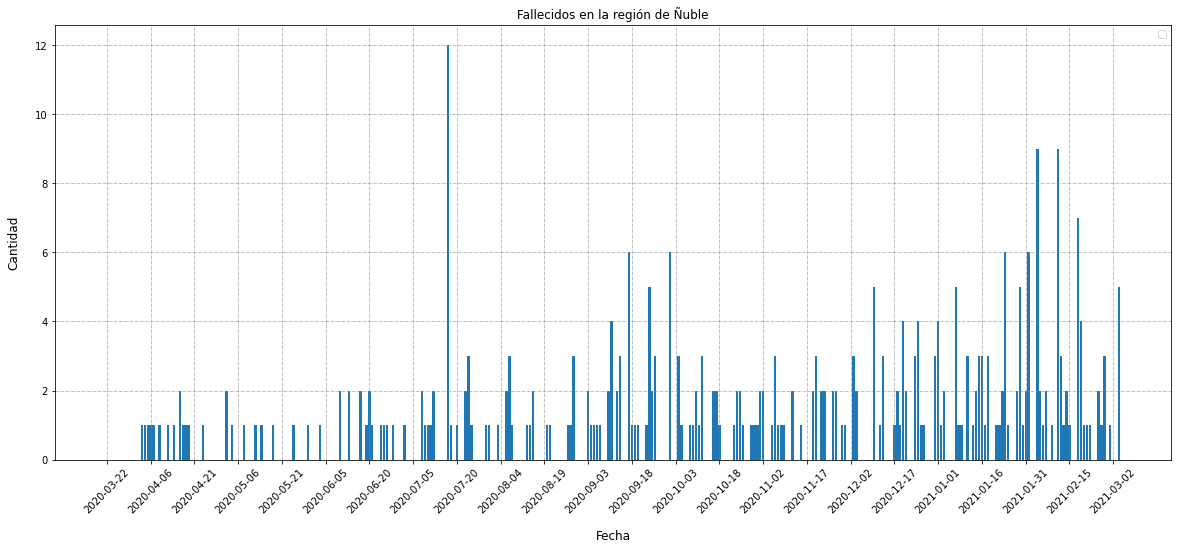

In [12]:
# Grafico imagen
plt.figure(figsize=(20,8))
plt.bar(fallecidos.fechas.values,fallecidos.fallecidos.values)
# plt.plot(df_fallecidos.fecha, df_fallecidos['total acumulados'].values)
plt.xticks(fallecidos.fechas.values[::15],rotation=45)
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.legend()
plt.xlabel('Fecha', labelpad = 15, fontsize = 12)
plt.ylabel('Cantidad',labelpad = 15,fontsize = 12)
plt.title('Fallecidos en la región de Ñuble', fontsize = 12)

#### E. Cuarentena

In [13]:
# Datos cargado wikipedia
# Revisar codigo computo cuarentena
wiki = r'E:\Udec\Magister\Tesis\Modelo\Modelo Kathyanistico\cuarentena_nuble.xlsx'
cuarentena = pd.read_excel(wiki)
cuarentena = cuarentena.drop(['Chillan','Chillan Viejo','Coihueco','San Carlos','Total '], axis=1).rename(columns={'Porcentaje':'Porcentaje Cuarentena'})
# cuarentena

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Porcentaje de cuarentena en Ñuble ')

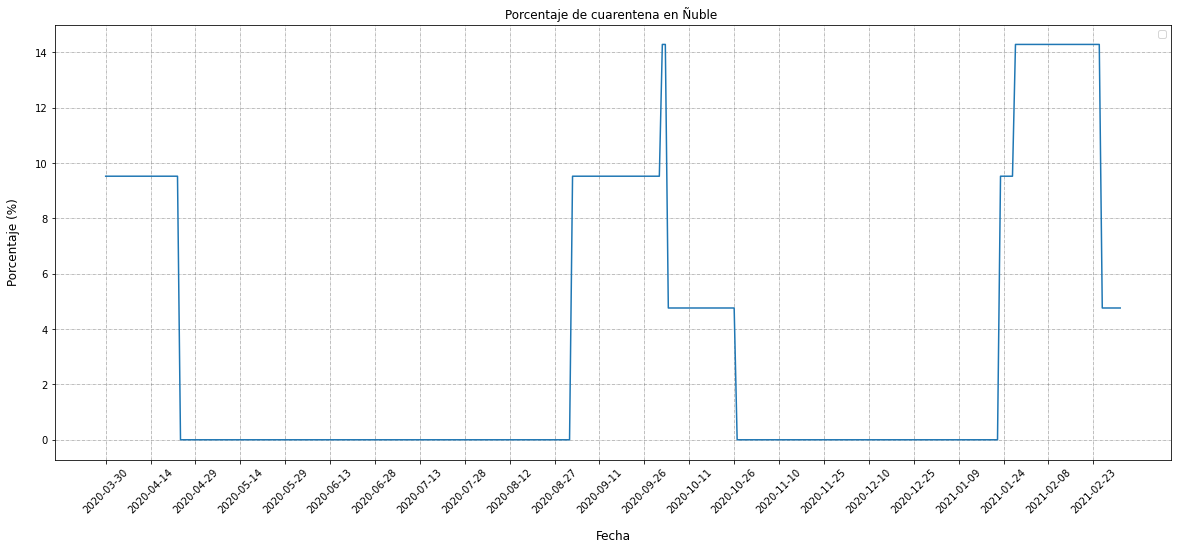

In [14]:
# Grafico imagen
plt.figure(figsize=(20,8))
plt.plot(cuarentena.fechas.values,cuarentena['Porcentaje Cuarentena'].values)
plt.xticks(cuarentena.fechas.values[::15],rotation=45)
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.legend()
plt.xlabel('Fecha', labelpad = 15, fontsize = 12)
plt.ylabel('Porcentaje (%)',labelpad = 15,fontsize = 12)
plt.title('Porcentaje de cuarentena en Ñuble ', fontsize = 12)

## MODELO

In [15]:
## Iniciamos semilla, para generar los mismos datos aleatorios para cada ejecucion
seed= 42

In [16]:
# Carga de datos, generados del codigo anterior
pcr_positivo      = pd.read_csv("../Modelo Kathyanistico/pcr_realizados_postivos.csv").rename({"fecha": "fechas"},axis=1)
df_uci            = pd.read_csv("../Modelo Kathyanistico/datos_uci.csv").rename({"dates": "fechas", "hospitalisations":"hospitalizaciones"},axis=1)
camas_total          = pd.read_csv("../Modelo Kathyanistico/total_camas.csv").rename({"dates": "fechas"},axis=1)
camas_usadas       = pd.read_csv("../Modelo Kathyanistico/camas_usadas.csv").rename({"dates": "fechas"},axis=1)
fallecidos_biobio = pd.read_csv("../Modelo Kathyanistico/defunciones_biobio.csv").rename({"fecha": "fechas"},axis=1)
cuarentena = pd.read_csv(r'E:\Udec\Magister\Tesis\Modelo\Modelo Kathyanistico\cuarentena_biobio.csv').drop(['Unnamed: 0'], axis = 1).rename(columns={"por_cuarenta": "Porcentaje Cuarentena"})

In [17]:
# Union de datos
datos=pd.merge(pd.merge(df_uci,df_camas),camasusadas)
datos = pd.merge(pd.merge(pcr_positivo,datos),fallecidos_biobio)
# cuarentena.fechas = cuarentena.fechas.dt.strftime('%Y-%m-%d')
datos = pd.merge(datos,cuarentena)

NameError: name 'df_camas' is not defined

In [ ]:
datos

In [ ]:
datos_grandes = datos.drop(["fechas"],axis=1).apply(dias_extras)
fechas = datos.fechas.values

In [ ]:
fecha_base = datetime.strptime(fechas[-1], "%Y-%m-%d")
fechas_generadas = [(fecha_base + timedelta(days = int(dia))).strftime("%Y-%m-%d")  for dia in np.arange(1,10+1)]
fechas = np.concatenate([fechas,fechas_generadas])

In [ ]:
datos_grandes["fechas"] = fechas

In [ ]:
datos = datos_grandes.copy()

In [ ]:
# plt.figure(figsize = (20,10))
# plt.plot(datos.pcr.values,label="pcrs")
# plt.plot(valor,label="generado",alpha=.6)
# plt.legend()

In [ ]:
datos.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
datos1 = datos.rename({"pcr": "PCR [x1]","positivos": "Positivos [x2]","total camas": "Total camas [x3]",
                      "camas usadas": "Camas usadas[x4]" , "fallecidos" : "Fallecidos [x5]",
                       "Porcentaje Cuarentena": "Porcentaje Cuarentena [x6]","hospitalizaciones":"Hospitalizaciones [y]" },axis=1)
datos1 = datos1[["fechas","PCR [x1]", "Positivos [x2]","Total camas [x3]", "Camas usadas[x4]" ,"Fallecidos [x5]", 
                 "Porcentaje Cuarentena [x6]","Hospitalizaciones [y]"]]
datos1

In [ ]:
#Separamos caracteristicas de variables que se predeciran. 
# Se separo en x e y, "y" corresponde a la cantidad de hospitalizaciones predichas
y = datos["hospitalizaciones"].values
X = datos.drop(["hospitalizaciones","fechas"],axis=1).values

In [ ]:
# se dividen los datos en conjunto de entrenamiento y de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [ ]:
# corr_matrix = datos.corr()
# corr_matrix

In [ ]:
# corr_matrix["pcr"].sort_values(ascending=False)
datos.columns

In [ ]:
atributos = ['pcr', 'positivos', 'hospitalizaciones',
       'total camas','camas usadas','fallecidos', 'Porcentaje Cuarentena']
# 
scatter_matrix(datos[atributos], figsize=(12, 8))
# save_fig("scatter_matrix_plot")

In [ ]:
import seaborn as sns 
correlacion = datos[atributos].corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlacion, annot =True)

In [ ]:
datos.describe()

## Arbol de regresion

In [ ]:
tree_reg = RandomForestRegressor(n_estimators = 10, random_state=42).fit(X_train, y_train)
# Obtiene la prediccion
y_pred = tree_reg .predict(X_test)

In [ ]:
print("r2_score", r2_score(y_test,y_pred))   #bondad del ajuste
print("mean_absolute_error", mean_absolute_error(y_test,y_pred)) 
print("mean_squared_error", mean_squared_error(y_test,y_pred))
print("mean_absolute_percentage_error", mean_absolute_percentage_error(y_test,y_pred))
print("median_absolute_error", median_absolute_error(y_test,y_pred))

In [ ]:
plt.scatter(y_test,y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid()
plt.title('Resultado RandomForestRegressor')

# regresion lineal

In [ ]:
# Realiza la regresion lineal
reg = LinearRegression(n_jobs=-1).fit(X_train, y_train) # n_jobs=-1 utiliza todos los nucleos
reg

In [ ]:
# Obtiene la prediccion
y_pred = reg.predict(X_test)

In [ ]:
print("r2_score", r2_score(y_test,y_pred))   #bondad del ajuste
print("mean_absolute_error", mean_absolute_error(y_test,y_pred)) 
print("mean_squared_error", mean_squared_error(y_test,y_pred))
print("mean_absolute_percentage_error", mean_absolute_percentage_error(y_test,y_pred))
print("median_absolute_error", median_absolute_error(y_test,y_pred))

In [ ]:
plt.scatter(y_test,y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid()
plt.title('Resultado Regresión Lineal')
plt.savefig('regresion_lineal.png')

In [ ]:
y_pred

# elastic net

In [ ]:
regr = ElasticNet(random_state=seed).fit(X_train, y_train)

In [ ]:
y_pred = regr.predict(X_test)

In [ ]:
print("r2_score", r2_score(y_test,y_pred))
print("mean_absolute_error", mean_absolute_error(y_test,y_pred))
print("mean_squared_error", mean_squared_error(y_test,y_pred))
print("mean_absolute_percentage_error", mean_absolute_percentage_error(y_test,y_pred))
print("median_absolute_error", median_absolute_error(y_test,y_pred))

In [ ]:
plt.scatter(y_test,y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid()
plt.title('Resultado Elastic Net')
plt.savefig('elastic_net.png')

# Red neuronal

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(100,200,100),random_state=seed, max_iter=500,activation="tanh").fit(X_train, y_train)

In [ ]:
y_pred = mlp.predict(X_test)

In [ ]:
print("r2_score", r2_score(y_test,y_pred))
print("mean_absolute_error", mean_absolute_error(y_test,y_pred))
print("mean_squared_error", mean_squared_error(y_test,y_pred))
print("mean_absolute_percentage_error", mean_absolute_percentage_error(y_test,y_pred))
print("median_absolute_error", median_absolute_error(y_test,y_pred))

In [ ]:
plt.scatter(y_test,y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid()
plt.title('Resultado Redes Neuronales')
plt.savefig('red_neuronal.png')

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
scores

## Serie de tiempo

In [ ]:
import os
from keras.layers import Dense, Dropout, Flatten, Reshape, LSTM
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = r"E:\Udec\Magister\Tesis\Machine Learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Images")
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
X,y = datos1[datos1.columns[1:7]].values,datos1[datos1.columns[7]].values

In [ ]:
datos1

In [ ]:
# X,y

In [ ]:
def create_segments_and_labels(X,y, time_steps, step):
    from scipy import stats
    # x, y, z acceleration as features
    N_FEATURES = X.shape[1]
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(X) - time_steps, step):
        xs = X[i: i + time_steps,0]
        ys = X[i: i + time_steps,1]
        zs = X[i: i + time_steps,2]
        ws = X[i: i + time_steps,3]
        vs = X[i: i + time_steps,4]
        us = X[i: i + time_steps,5]
        # Retrieve the most often used label in this segment
        label = stats.mode(y[i: i + time_steps])[0][0]
        segments.append([xs, ys, zs, ws,vs, us])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [ ]:
TIME_PERIODS = 1
STEP_DISTANCE =1
batch_size = 16
N_FEATURES =  X.shape[1]

input_shape = (TIME_PERIODS*N_FEATURES)
input_shape

# Dividir entre train y test
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
Xtrain, Xtest = X[0:train_size,:], X[train_size:len(X),:]
ytrain, ytest = y[0:train_size], y[train_size:len(X)]

In [ ]:
x_train, y_train = create_segments_and_labels(Xtrain,
                                              ytrain,
                                              TIME_PERIODS,
                                              STEP_DISTANCE
                                              )

x_test, y_test = create_segments_and_labels(Xtest,
                                              ytest,
                                              TIME_PERIODS,
                                              STEP_DISTANCE
                                              )

## Perceptron

In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Reshape((TIME_PERIODS, N_FEATURES), input_shape=(input_shape,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='relu'))
# print(model.summary())

In [ ]:
# callbacks_list = [
#     keras.callbacks.ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
#         monitor='val_loss', save_best_only=True),
#     keras.callbacks.EarlyStopping(monitor='acc', patience=1)
# ]


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
# model.compile(loss='mean_squared_error', optimizer=optimizer)
history = model.fit(x_train, y_train, epochs=1000, batch_size=batch_size, verbose=2, 
#                     callbacks=callbacks_list
                   )

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(history.epoch,history.history['loss'])
# plt.plot(history.epoch,history.history['val_loss'])
plt.title('Optimizacion')
plt.xlabel('epocas')
plt.ylabel('mse')
# plt.yscale("log")

In [ ]:
# Estimate model performance
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

In [ ]:
# generate predictions for training
trainPredict = np.squeeze(model.predict(x_train))
testPredict  = np.squeeze(model.predict(x_test))

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(trainPredict,label="train_predict")
plt.plot(y_train,label="train")

puntos_base = np.arange(len(y_train),len(y_train)+len(y_test),1)-2
plt.plot(puntos_base,testPredict,label="test_predict")
plt.plot(puntos_base,y_test,label="test")
plt.legend()

## LSTM

In [ ]:
# # create and fit Multilayer Perceptron model
model = Sequential()
# model.add(Reshape((TIME_PERIODS, N_FEATURES), input_shape=(input_shape,)))
model.add(LSTM(50,  input_shape=(x_train[0].shape), return_sequences=True))
model.add(LSTM(50 ))
# model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='relu'))
print(model.summary())

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
# model.compile(loss='mean_squared_error', optimizer=optimizer)
history = model.fit(x_train, y_train, epochs=1000, batch_size=batch_size, verbose=2, 
#                     callbacks=callbacks_list
                   )

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(history.epoch,history.history['loss'])
# plt.plot(history.epoch,history.history['val_loss'])
plt.title('Optimizacion')
plt.xlabel('epocas')
plt.ylabel('mse')
# plt.yscale("log")

In [ ]:
# Estimate model performance
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

In [ ]:
# generate predictions for training
trainPredict = np.squeeze(model.predict(x_train))
testPredict  = np.squeeze(model.predict(x_test))

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(trainPredict,label="train_predict")
plt.plot(y_train,label="train")

puntos_base = np.arange(len(y_train),len(y_train)+len(y_test),1)-2
plt.plot(puntos_base,testPredict,label="test_predict")
plt.plot(puntos_base,y_test,label="test")
plt.legend()